In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Data Loading
We get the train and test data

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Explorative Data Analysis:
let's see if any data is missing and what data we're working with:

In [4]:
train_data.info()

train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


It seems some ages are missing, as well as a lot of cabin ID's.

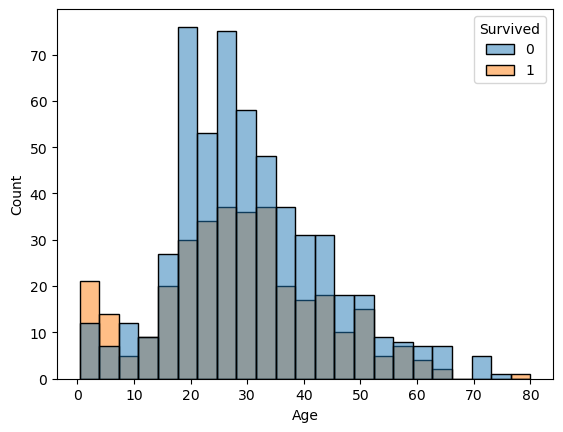

In [5]:
#fill age with mean, so we don't throw away usefull info

train_data["Age"].interpolate(method ='linear', limit_direction ='forward', inplace=True)
train_data["Age"].describe()
sns.histplot(train_data, x="Age", hue="Survived")

#also replace in test set!
test_data["Age"].interpolate(method ='linear', limit_direction ='forward', inplace=True)

First guess: women survived more often, so we make 2 new vectors: one for men and women, calculating the rate of men/women who survived the tragedy.

In [6]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived: ", rate_women)

% of women who survived:  0.7420382165605095


In [7]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived: ", rate_men)

% of men who survived:  0.18890814558058924


<AxesSubplot:xlabel='Sex', ylabel='count'>

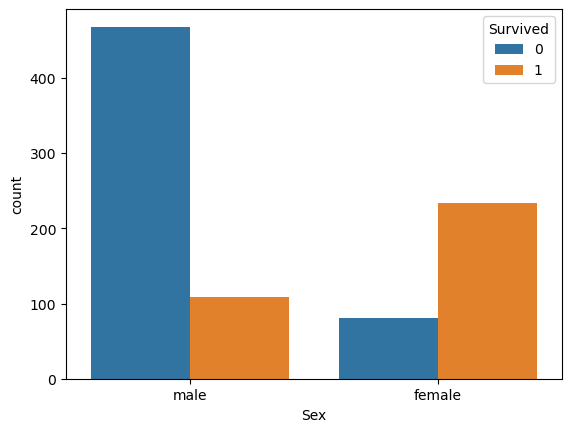

In [8]:
sns.countplot(data=train_data, x="Sex", hue="Survived")

As seen above, 75% of women on board survived, while only 19% of men got rescued. This means that gender is a very strong indicator of survival!

## Further EDA

<AxesSubplot:xlabel='Pclass', ylabel='count'>

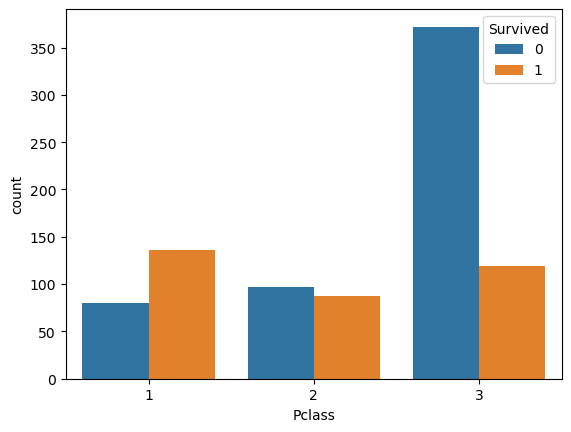

In [9]:
#Plotting unique values:
sns.countplot(data=train_data, x="Pclass", hue="Survived")

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.062164,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.304934,0.083081,0.018443,-0.549500
Age,-0.062164,-0.304934,1.000000,-0.213410,-0.170013,0.087119
SibSp,-0.035322,0.083081,-0.213410,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.170013,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.087119,0.159651,0.216225,1.000000


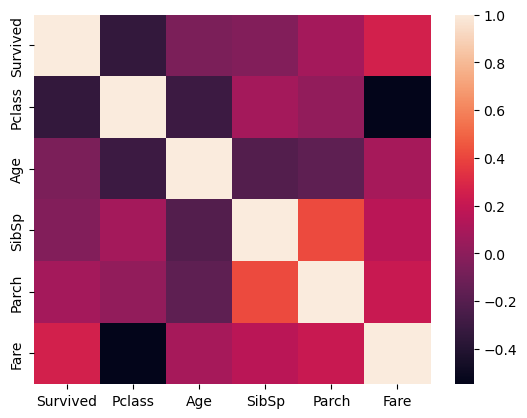

In [10]:
numerical = ["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]
sns.heatmap(data = train_data[numerical].corr())
train_data[numerical].corr()

In [11]:
# Random Forest Model:

from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch", "Age"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators = 100,
                              max_depth = 10, 
                              random_state = 40)
model.fit(X,y)
train_predictions = model.predict(X)
test_predictions = model.predict(X_test)

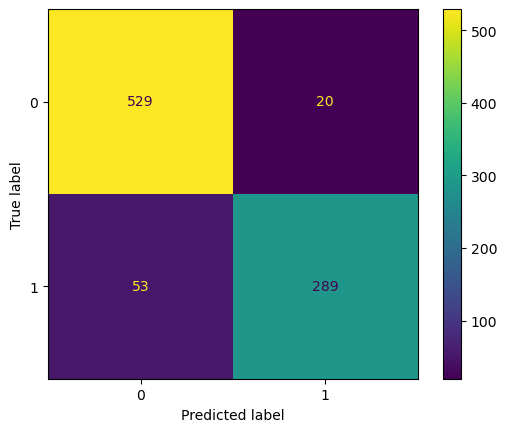

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y, train_predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [13]:
from sklearn.metrics import classification_report
 
print(classification_report(y, train_predictions))


              precision    recall  f1-score   support

           0       0.91      0.96      0.94       549
           1       0.94      0.85      0.89       342

    accuracy                           0.92       891
   macro avg       0.92      0.90      0.91       891
weighted avg       0.92      0.92      0.92       891



In [14]:
# output results
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': test_predictions})
output.info()
output.to_csv('submission.csv', index = False)
print("Submission succesfully saved!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB
Submission succesfully saved!
